In [1]:
import os
import docx
import PyPDF2
import io 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import pandas as pd
import pdfplumber
import pikepdf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
import joblib


In [2]:
def get_text(filename):
    full_text = ''
    if filename.endswith('.docx'):
        doc = docx.Document(filename)
        for para in doc.paragraphs:
            full_text = full_text + para.text
    elif filename.endswith('.pdf'):  
        with open(filename, "rb") as pdf_file:
            pdoc = PyPDF2.PdfFileReader(filename)
            number_of_pages = pdoc.getNumPages()
            page = pdoc.pages[0]
            page_content = page.extractText()
        for paragraph in page_content:
            full_text =  full_text + paragraph
    else:
        try:
            import aspose.words as aw
            output = aw.Document()
            output.remove_all_children()
            input = aw.Document(filename)
            output.append_document(input, aw.ImportFormatMode.KEEP_SOURCE_FORMATTING)
            output.save("Output.docx");
            doc = docx.Document('Output.docx')
            for para in doc.paragraphs:
                full_text = full_text + para.text
            full_text = full_text[79:]
        except:
            filename.endswith(".zip")
    return full_text


In [3]:
def token_text(ext_text):
    punc = '''!()-[]{};:'"\,.<>/?@#$%^&*_~'''
    punc_text = " "
    for ele in ext_text:
        if ele in punc:
            punc_text = ext_text.replace(ele, "")
    stop_words = set(stopwords.words('english'))
    punc_text.split()
    word_tokens = word_tokenize(punc_text)
    tokenized_text = [w for w in word_tokens if not w.lower() in stop_words]
    tokenized_text = []
    for w in word_tokens:
        if w not in stop_words:
            tokenized_text.append(w)
    return tokenized_text


In [4]:
terms = {
    'WorkDay ERP': ['workday', 'workday consultant', 'workday hcm', 'eib', 'picof', 'workday studio', 'nnbound/outbound integrations'],
    'Peoplesoft': ['peoplesoft', 'pia', 'ccb', 'birt', 'peci', 'ccw', 'pum', 'people tools', 'peoplesoft implementation', 'peoplesoft components', 'peoplesoft dba', 'peoplesoft admin', 'peoplesoft admin/dba', 'peopleSoft fscm', 'peopletoolsupgrade', 'peopletools upgrade', 'process scheduler servers', 'peoplesoft hrms', 'peopleSoft consultant', 'peoplesoft cloud', 'PeopleSoft migrations', 'eoplesoft Testing Framework', 'pure internet architecture'],
    'Database Developer': ['sql', 'sql server', 'ms sql server', 'msbi', 'sql developer', 'ssis', 'ssrs', 'ssms', 't-sql', 'tsql', 'Razorsql', 'razor sql', 'triggers', 'powerbi', 'power bi', 'oracle sql', 'pl/sql', 'pl\sql', 'oracle', 'oracle 11g', 'oledb', 'cte', 'ddl', 'dml', 'etl', 'mariadb', 'maria db'],
    'Java Developer': ['reactjs', 'react js', 'react js developer', 'html', 'React JS', 'css3', 'xml', 'javascript', 'html5', 'boostrap', 'jquery', 'redux', 'php', 'node js', 'nodejs', 'apache', 'netbeans', 'nestjs', 'nest js', 'react developer', 'react hooks', 'jenkins']
}

all_terms = ['workday', 'hcm', 'eib', 'picof', 'workday hcm', 'workday studio', 'nnbound/outbound integrations', 'peoplesoft', 'pia', 'ccb', 'birt', 'peci', 'ccw', 'pum', 'people tools', 'peoplesoft implementation', 'peoplesoft components', 'peoplesoft dba', 'peoplesoft admin', 'peoplesoft admin/dba', 'peopleSoft fscm', 'peopletoolsupgrade', 'peopletools upgrade', 'process scheduler servers', 'peoplesoft hrms', 'peopleSoft consultant', 'peopledoft cloud', 'PeopleSoft migrations', 'eoplesoft Testing Framework', 'pure internet architecture', 'sql', 'sql server', 'ms sql server', 'msbi', 'sql developer', 'ssis', 'ssrs', 'ssms', 't-sql', 'tsql', 'Razorsql', 'razor sql', 'triggers', 'powerbi', 'power bi', 'oracle sql', 'pl/sql', 'pl\sql', 'oracle', 'oracle 11g', 'oledb', 'cte', 'ddl', 'dml', 'etl', 'mariadb', 'maria db', 'reactjs', 'react js', 'react js developer', 'html', 'css3', 'xml', 'javascript', 'html5', 'boostrap', 'jquery', 'redux', 'php', 'node js', 'nodejs', 'apache', 'netbeans', 'nestjs', 'nest js', 'react developer', 'react hooks', 'jenkins']


In [5]:
def role_applied(text):
    for i in range(len(text)):
        text[i] = text[i].lower()
    
    for area in terms.keys():
        if area == 'WorkDay ERP':
            for word in terms[area]:
                if word in text:
                    role = area
                    return role
                
        elif area == 'Peoplesoft':
            for word in terms[area]:
                if word in text:
                    role = area
                    return role   
                
        elif area == 'Database Developer':
            for word in terms[area]:
                if word in text:
                    role = area
                    return role
            
        elif area == 'Java Developer':
            for word in terms[area]:
                if word in text:
                    role = area
                    return role
        else:
            role = "Fresher"
            return role


In [6]:
def contact_details(text):
    name = ''  
    for i in range(0, 3):
        name = " ".join([name, text[i]])
    return name


In [7]:
def extract_experience(text):
    global sent
    text = text.split()
    for i in range(len(text)-2):
        text[i].lower()
        if text[i] == 'years':
            sent = text[i-2] + ' ' + text[i-1] + ' ' + text[i] + ' ' + text[i+1] + ' ' + text[i+2]
            return sent


In [8]:
def extract_skill_set(text):
    t = []
    for i in range(len(text)):
        if text[i] in all_terms:
            if text[i] in t:
                continue
            t.append(text[i]) 
    return t


In [9]:
ResumeText = pd.DataFrame([], columns=['Name', 'RoleApplied', 'Experience', 'SkillSet', 'TextInfo'])


In [10]:
path = r'C:\Users\prasa\Downloads\Resumes\Resumes\Resumes'
text = []


In [11]:
for filename in os.listdir(path):
    filename = os.path.join(path, filename)
    ext_text = get_text(filename)
    tok_text = token_text(ext_text)
    role = role_applied(tok_text)
    name = contact_details(tok_text)
    experience = extract_experience(ext_text)
    skills = extract_skill_set(tok_text)
    new_row = [name, role, experience, skills, tok_text]  
    ResumeText.loc[len(ResumeText)] = new_row


In [12]:
ResumeText['Experience'].str.extract("(\d.\d+|\d+)")


,0
0,2.4
1,4
2,2.11
3,5.1
4,2.4
...,...
75,6
76,3.2
77,5.3
78,4.2


In [13]:
ResumeText[ResumeText['RoleApplied'].isna()]


,Name,RoleApplied,Experience,SkillSet,TextInfo
60,anjani priyadarshini react,None,developer 9 years of experienceThis,[],"[anjani, priyadarshini, react, js, developer, ..."
62,venkatalakshmi pedireddy software,None,ReactJSExperience 3 years in React,[],"[venkatalakshmi, pedireddy, software, develope..."


In [14]:
ResumeText[ResumeText['Name'].isna()]


,Name,RoleApplied,Experience,SkillSet,TextInfo


In [15]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

lb = preprocessing.LabelEncoder()
ResumeText['Roleapplied '] = lb.fit_transform(ResumeText['RoleApplied'])
ResumeText['Text'] = ResumeText['TextInfo'].apply(lambda x: ','.join(map(str, x)))
ResumeText


,Name,RoleApplied,Experience,SkillSet,TextInfo,Roleapplied,Text
0,anil kumar maddukuri,Database Developer,Developer Summary2.4 years of experience,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, e...","[anil, kumar, maddukuri, sql, &, msbi, develop...",0,"anil,kumar,maddukuri,sql,&,msbi,developer,summ..."
1,aradhana tripathi current,Database Developer,than 4 years of working,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]","[aradhana, tripathi, current, location, :, gac...",0,"aradhana,tripathi,current,location,:,gachibowl..."
2,buddha vamsi career,Database Developer,OBJECTIVE:Have 2.11 years of IT,"[sql, oracle, triggers, cte, etl]","[buddha, vamsi, career, objective, :, have, 21...",0,"buddha,vamsi,career,objective,:,have,211,years..."
3,chinna subbarayudu mdob,WorkDay ERP,around 5.1 years of IT,"[workday, hcm, etl, eib, xml, ccw, picof, peci...","[chinna, subbarayudu, mdob, 06thmarch, 1994nat...",3,"chinna,subbarayudu,mdob,06thmarch,1994national..."
4,nameroleappliedexperienceskillsettextinforole...,WorkDay ERP,"Developer,Developer Summary2.4 years of experi...","[ssms, msbi, etl, ssis, ssrs, mariadb, eib, or...",[nameroleappliedexperienceskillsettextinforole...,3,nameroleappliedexperienceskillsettextinforolea...
...,...,...,...,...,...,...,...
75,kumar ssworkday |,WorkDay ERP,Summary:Having 6+ years of experience,"[hcm, workday, eib, xml, peci, peoplesoft]","[kumar, ssworkday, |, hcm, |, fcmworkday, cons...",3,"kumar,ssworkday,|,hcm,|,fcmworkday,consultant,..."
76,tatikonda kiran kumarcareer,Database Developer,with 3.2 years of total,"[sql, cte, t-sql, triggers]","[tatikonda, kiran, kumarcareer, objective, a, ...",0,"tatikonda,kiran,kumarcareer,objective,a,reward..."
77,venkateswarlu.bworkday consultant having,WorkDay ERP,Having 5.3 years of experience,"[workday, hcm, birt, eib, xml]","[venkateswarlu.bworkday, consultant, having, 5...",3,"venkateswarlu.bworkday,consultant,having,5.3,y..."
78,vinay kumar v,WorkDay ERP,Having 4.2 years of Total,"[workday, hcm, eib, xml, peoplesoft]","[vinay, kumar, v, workday, functional, consult...",3,"vinay,kumar,v,workday,functional,consultantexp..."


In [16]:
stopwords = stopwords.words("english")
from nltk.stem.porter import PorterStemmer 
import re

ps = PorterStemmer()

def preprocess(x):
    x = re.sub('[^a-zA-Z ]', ' ', x)
    x = x.lower()
    x = x.split()  
    x = [word for word in x if word not in set(stopwords.words('english'))]  
    x = [ps.stem(word) for word in x] 
    x = " ".join(x)
    return x

ResumeText.head()


,Name,RoleApplied,Experience,SkillSet,TextInfo,Roleapplied,Text
0,anil kumar maddukuri,Database Developer,Developer Summary2.4 years of experience,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, e...","[anil, kumar, maddukuri, sql, &, msbi, develop...",0,"anil,kumar,maddukuri,sql,&,msbi,developer,summ..."
1,aradhana tripathi current,Database Developer,than 4 years of working,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]","[aradhana, tripathi, current, location, :, gac...",0,"aradhana,tripathi,current,location,:,gachibowl..."
2,buddha vamsi career,Database Developer,OBJECTIVE:Have 2.11 years of IT,"[sql, oracle, triggers, cte, etl]","[buddha, vamsi, career, objective, :, have, 21...",0,"buddha,vamsi,career,objective,:,have,211,years..."
3,chinna subbarayudu mdob,WorkDay ERP,around 5.1 years of IT,"[workday, hcm, etl, eib, xml, ccw, picof, peci...","[chinna, subbarayudu, mdob, 06thmarch, 1994nat...",3,"chinna,subbarayudu,mdob,06thmarch,1994national..."
4,nameroleappliedexperienceskillsettextinforole...,WorkDay ERP,"Developer,Developer Summary2.4 years of experi...","[ssms, msbi, etl, ssis, ssrs, mariadb, eib, or...",[nameroleappliedexperienceskillsettextinforole...,3,nameroleappliedexperienceskillsettextinforolea...


In [17]:
ResumeText.TextInfo = ResumeText.TextInfo.apply(lambda x: [ps.stem(word) for word in x])
ResumeText.head()


,Name,RoleApplied,Experience,SkillSet,TextInfo,Roleapplied,Text
0,anil kumar maddukuri,Database Developer,Developer Summary2.4 years of experience,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, e...","[anil, kumar, maddukuri, sql, &, msbi, develop...",0,"anil,kumar,maddukuri,sql,&,msbi,developer,summ..."
1,aradhana tripathi current,Database Developer,than 4 years of working,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]","[aradhana, tripathi, current, locat, :, gachib...",0,"aradhana,tripathi,current,location,:,gachibowl..."
2,buddha vamsi career,Database Developer,OBJECTIVE:Have 2.11 years of IT,"[sql, oracle, triggers, cte, etl]","[buddha, vamsi, career, object, :, have, 211, ...",0,"buddha,vamsi,career,objective,:,have,211,years..."
3,chinna subbarayudu mdob,WorkDay ERP,around 5.1 years of IT,"[workday, hcm, etl, eib, xml, ccw, picof, peci...","[chinna, subbarayudu, mdob, 06thmarch, 1994nat...",3,"chinna,subbarayudu,mdob,06thmarch,1994national..."
4,nameroleappliedexperienceskillsettextinforole...,WorkDay ERP,"Developer,Developer Summary2.4 years of experi...","[ssms, msbi, etl, ssis, ssrs, mariadb, eib, or...",[nameroleappliedexperienceskillsettextinforole...,3,nameroleappliedexperienceskillsettextinforolea...


In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

lb = preprocessing.LabelEncoder()
ResumeText['role'] = lb.fit_transform(ResumeText['RoleApplied'])
df = pd.DataFrame(ResumeText.drop(["Name"], axis=1))
df = df.drop(["RoleApplied"], axis=1)
df = df.drop(["Experience"], axis=1)
df = df.drop(["TextInfo"], axis=1)
df.head()


,SkillSet,Roleapplied,Text,role
0,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, e...",0,"anil,kumar,maddukuri,sql,&,msbi,developer,summ...",0
1,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]",0,"aradhana,tripathi,current,location,:,gachibowl...",0
2,"[sql, oracle, triggers, cte, etl]",0,"buddha,vamsi,career,objective,:,have,211,years...",0
3,"[workday, hcm, etl, eib, xml, ccw, picof, peci...",3,"chinna,subbarayudu,mdob,06thmarch,1994national...",3
4,"[ssms, msbi, etl, ssis, ssrs, mariadb, eib, or...",3,nameroleappliedexperienceskillsettextinforolea...,3


In [19]:
df['SkillSet'] = df['SkillSet'].apply(lambda x: ','.join(map(str, x)))
df.head()


,SkillSet,Roleapplied,Text,role
0,"sql,msbi,ssms,ssis,ssrs,triggers,cte,etl,oledb",0,"anil,kumar,maddukuri,sql,&,msbi,developer,summ...",0
1,"sql,mariadb,triggers,ddl,dml,t-sql,ssms",0,"aradhana,tripathi,current,location,:,gachibowl...",0
2,"sql,oracle,triggers,cte,etl",0,"buddha,vamsi,career,objective,:,have,211,years...",0
3,"workday,hcm,etl,eib,xml,ccw,picof,peci,peoples...",3,"chinna,subbarayudu,mdob,06thmarch,1994national...",3
4,"ssms,msbi,etl,ssis,ssrs,mariadb,eib,oracle,wor...",3,nameroleappliedexperienceskillsettextinforolea...,3


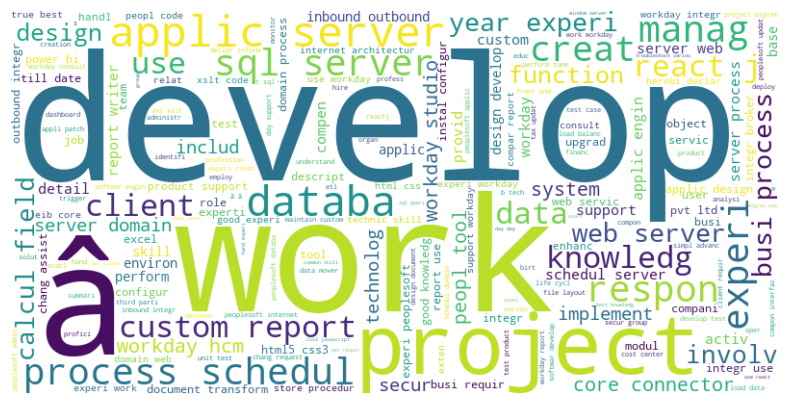

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'TextInfo' column contains lists of words
ResumeText['TextInfoString'] = ResumeText['TextInfo'].apply(lambda x: ' '.join(x))

# Combine all the text into a single string
text_data = ' '.join(ResumeText['TextInfoString'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


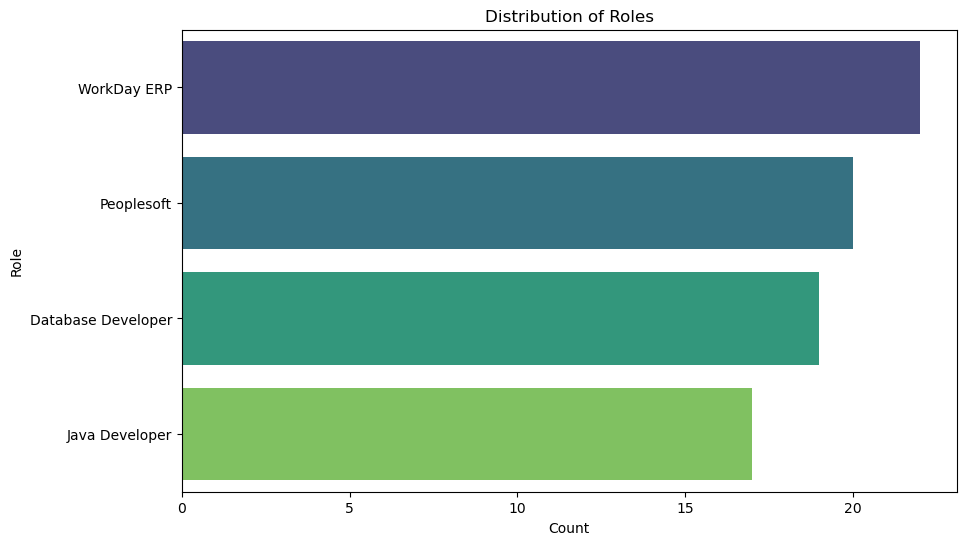

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'RoleApplied' is the column containing role information
plt.figure(figsize=(10, 6))
sns.countplot(y='RoleApplied', data=ResumeText, order=ResumeText['RoleApplied'].value_counts().index, palette='viridis')
plt.title('Distribution of Roles')
plt.xlabel('Count')
plt.ylabel('Role')
plt.show()


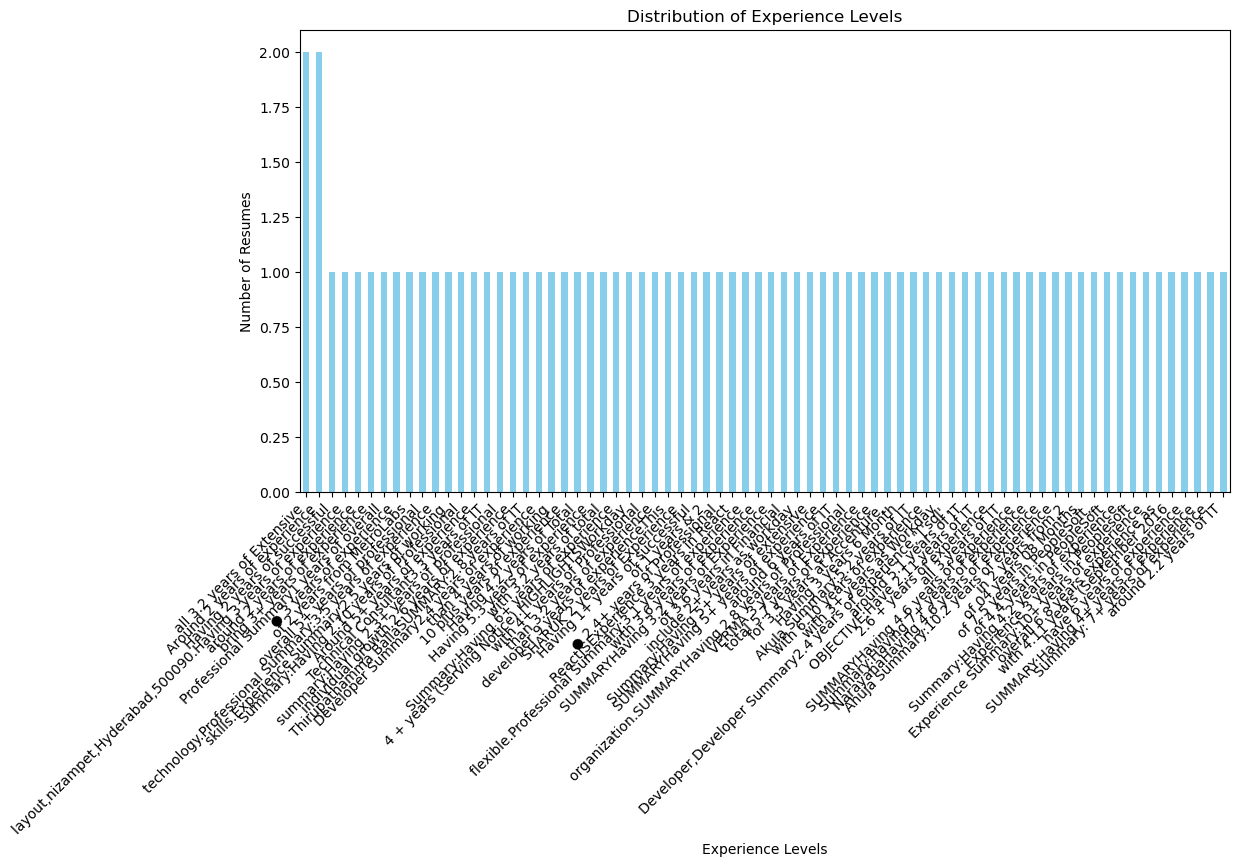

In [34]:
import matplotlib.pyplot as plt

# Assuming 'Experience' is the column containing experience information
experience_counts = ResumeText['Experience'].value_counts()
plt.figure(figsize=(12, 6))
experience_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Experience Levels')
plt.ylabel('Number of Resumes')
plt.title('Distribution of Experience Levels')
plt.xticks(rotation=45, ha='right')
plt.show()


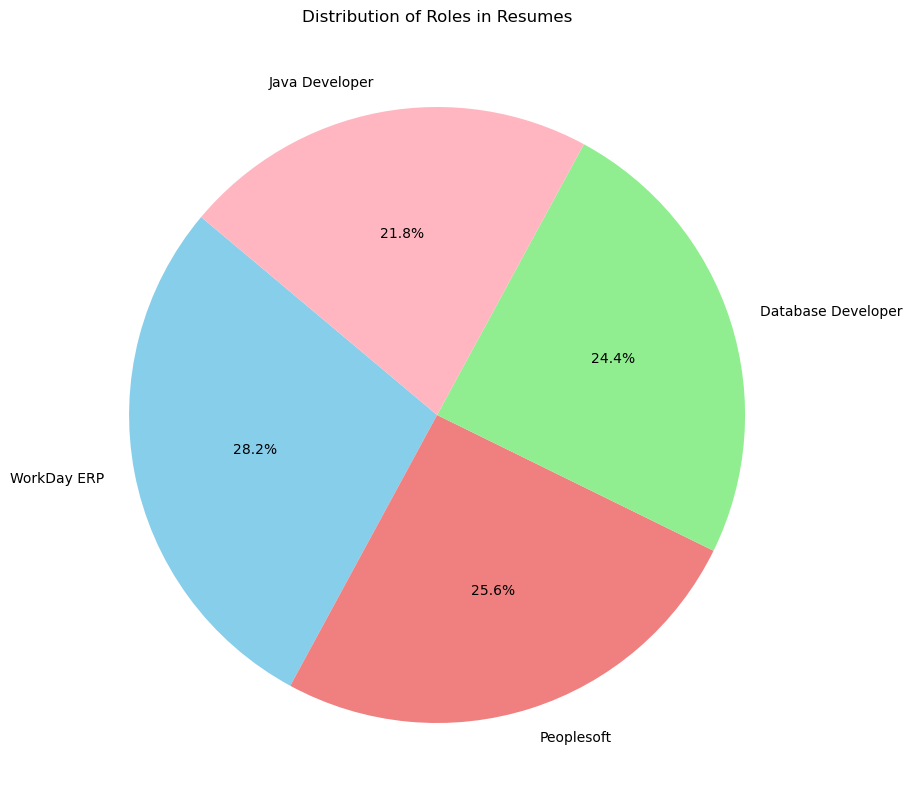

In [35]:
import matplotlib.pyplot as plt

# Assuming 'RoleApplied' is the column containing role information
role_counts = ResumeText['RoleApplied'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(role_counts, labels=role_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightpink'])
plt.title('Distribution of Roles in Resumes')
plt.show()


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

required_text = df['SkillSet'].values
required_target = df['role'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english'
)
word_vectorizer.fit_transform(required_text).toarray()
WordFeatures = word_vectorizer.transform(required_text)

print("Feature completed ...")


Feature completed ...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, required_target, random_state=123, test_size=0.30, shuffle=True, stratify=required_target)
X_train.shape, X_test.shape


((56, 37), (24, 37))

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_train, y_train), clf.score(X_test, y_test)


(0.9464285714285714, 0.9166666666666666)

In [23]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# Initialize and fit the OneVsRestClassifier with different classifiers
classifiers = {
    'SVM': OneVsRestClassifier(SVC()),
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier()),
    'Naive Bayes': OneVsRestClassifier(MultinomialNB())
}

results = {}

# Iterate through classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy}")

# Display results
print("\nResults:")
print(results)


SVM Accuracy: 0.9166666666666666
Decision Tree Accuracy: 0.875
Naive Bayes Accuracy: 0.9583333333333334

Results:
{'SVM': 0.9166666666666666, 'Decision Tree': 0.875, 'Naive Bayes': 0.9583333333333334}


In [24]:
nb_clf = OneVsRestClassifier(MultinomialNB())
nb_clf.fit(X_train, y_train)
joblib.dump(nb_clf, 'naive_bayes_model.pkl')


['naive_bayes_model.pkl']

In [25]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

# Save the TfidfVectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english'
)
WordFeatures = vectorizer.fit_transform(required_text)
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [26]:
label_encoder = LabelEncoder()
label_encoder.fit(ResumeText['RoleApplied'])
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [28]:
ResumeText.to_csv('C:/Users/prasa/Desktop/NLP_Resume_Classification_Final/ResumeExtracted_NLP.csv', index=False)